# Other Samplers

Trey V. Wenger (c) August 2024

Here we demonstrate the use of non-standard samplers with `bayes_spec`.

In [1]:
# General imports
from IPython.display import display, Image
    
import os
import pickle

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None

# plot directory and extension
figdir = "figures"
ext = "png"
if not os.path.isdir(figdir):
    os.mkdir(figdir)
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.4.1+0.gedd3257.dirty


## Data Format

In [2]:
from bayes_spec import SpecData

# spectral axis definition
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

# Our model only expects a single observation named "observation"
# Note that because we "named" the spectrum "observation" here,
# we must use the same name in the model definition above
observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

## Simulating Data

Text(0, 0.5, 'Brightness Temperature (K)')

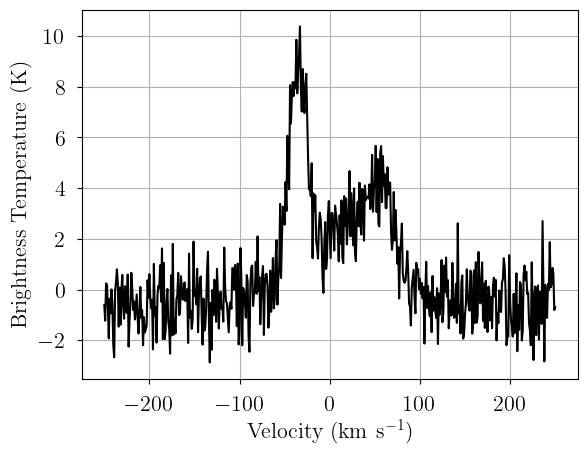

In [3]:
from bayes_spec.models import GaussLineNoise

# Initialize and define the model
model = GaussLineNoise(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeff = 1.0, # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 1.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "rms_observation": 1.0, # spectral rms (K)
    "observation_baseline_norm": [-0.5, 0.2, 0.05], # normalized baseline coefficients
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## MCMC

First, let's revisit the NUTS sampler used in the other notebooks.

In [5]:
model = GaussLineNoise(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeff = 1.0, # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

Let's use a lot of chains and the `pymc` `"auto"` initialization.

In [6]:
model.sample(
    init = "auto",
    tune = 1000,
    draws = 1000,
    chains = 8,
    cores = 8,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.


In [7]:
model.solve(p_threshold=0.9)

GMM converged to unique solution
Label order mismatch in solution 0
Chain 0 order: [1 0 2]
Chain 1 order: [0 2 1]
Chain 2 order: [0 1 2]
Chain 3 order: [0 1 2]
Chain 4 order: [2 0 1]
Chain 5 order: [2 1 0]
Chain 6 order: [0 1 2]
Chain 7 order: [2 0 1]
Adopting (first) most common order: [0 1 2]


Sampling: [observation]


Output()

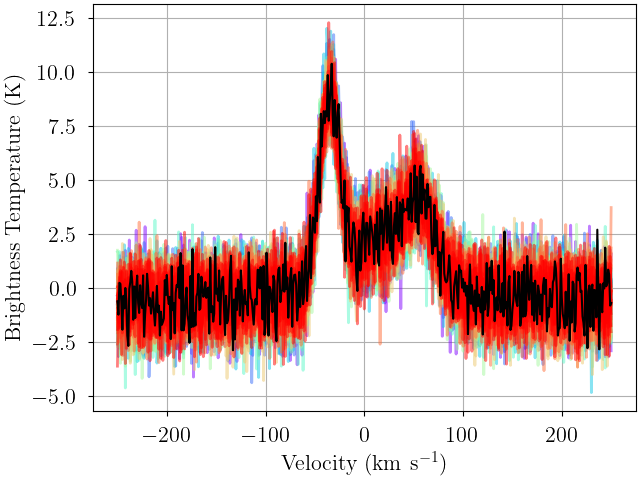

In [8]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive_mcmc.{ext}"
)
Image(f"{figdir}/posterior_predictive_mcmc.{ext}")

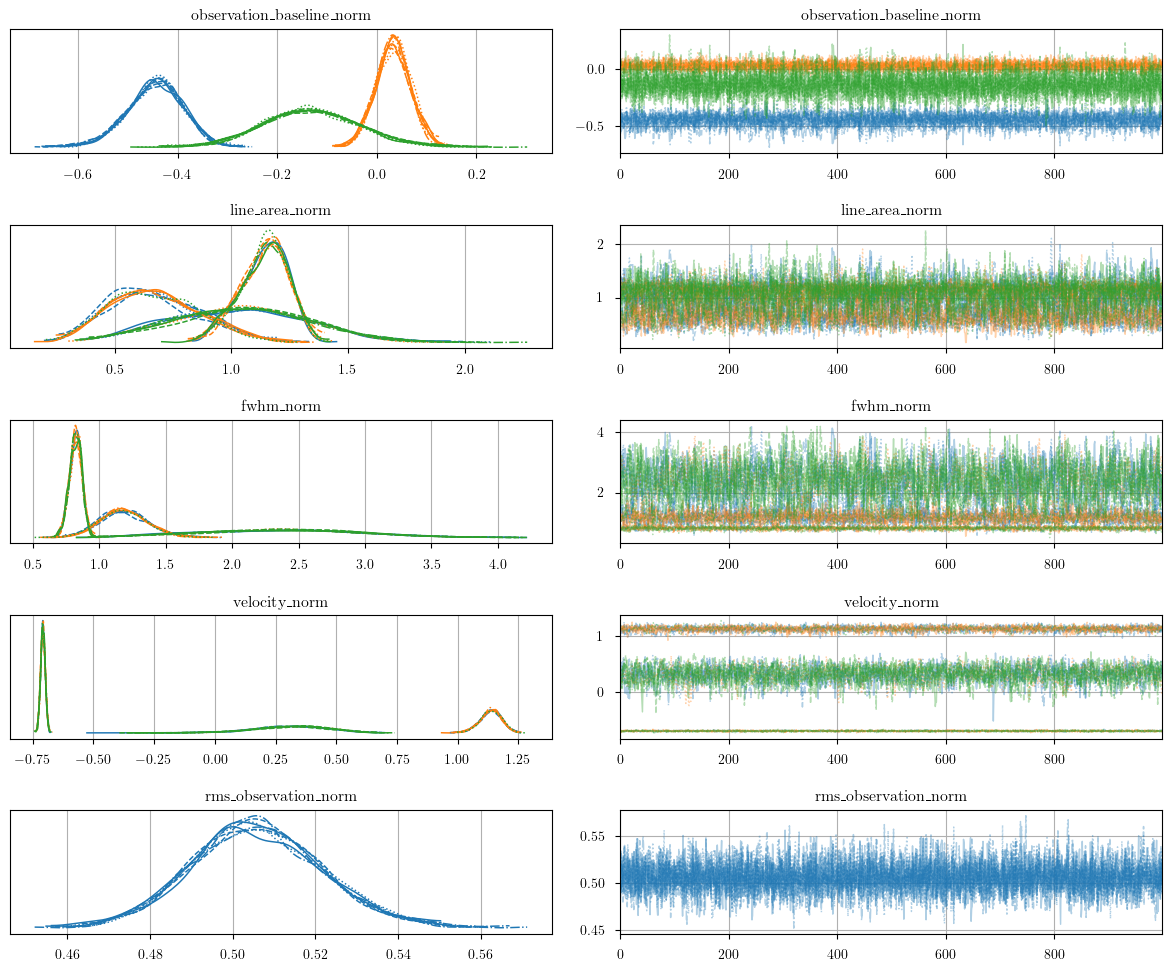

In [9]:
model.plot_traces(f"{figdir}/traces_mcmc.{ext}")
Image(f"{figdir}/traces_mcmc.{ext}")

In [10]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    3.499   0.635    2.403    4.679      0.013   
amplitude[1]                    8.679   0.466    7.803    9.537      0.009   
amplitude[2]                    2.777   0.311    2.196    3.369      0.005   
fwhm[0]                        35.615   5.555   25.824   46.914      0.100   
fwhm[1]                        24.642   1.434   21.951   27.388      0.026   
fwhm[2]                        70.529  18.174   34.465  101.217      0.416   
fwhm_norm[0]                    1.187   0.185    0.861    1.564      0.003   
fwhm_norm[1]                    0.821   0.048    0.732    0.913      0.001   
fwhm_norm[2]                    2.351   0.606    1.149    3.374      0.014   
line_area[0]                  134.436  38.471   65.842  205.364      0.792   
line_area[1]                  227.904  20.696  188.145  264.781      0.444   
line_area[2]                  208.411  57.770  101.725  312.383      1.257   
line_area_norm[0]               0.672   0.192    0.329    1.027      0.004   
line_area_norm[1]               1.140   0.103    0.941    1.324      0.002   
line_area_norm[2]               1.042   0.289    0.509    1.562      0.006   
observation_baseline_norm[0]   -0.445   0.057   -0.553   -0.342      0.001   
observation_baseline_norm[1]    0.033   0.035   -0.036    0.095      0.000   
observation_baseline_norm[2]   -0.131   0.098   -0.317    0.053      0.001   
rms_observation                 1.012   0.032    0.949    1.069      0.000   
rms_observation_norm            0.506   0.016    0.474    0.534      0.000   
velocity[0]                    56.775   2.215   52.601   60.952      0.038   
velocity[1]                   -35.394   0.476  -36.288  -34.502      0.007   
velocity[2]                    15.677   7.554    1.823   29.561      0.146   
velocity_norm[0]                1.135   0.044    1.052    1.219      0.001   
velocity_norm[1]               -0.708   0.010   -0.726   -0.690      0.000   
velocity_norm[2]                0.314   0.151    0.036    0.591      0.003   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.009    2598.0    4540.0    1.0  
amplitude[1]                    0.006    2959.0    5003.0    1.0  
amplitude[2]                    0.003    4542.0    5268.0    1.0  
fwhm[0]                         0.070    3115.0    4385.0    1.0  
fwhm[1]                         0.018    3043.0    3956.0    1.0  
fwhm[2]                         0.294    1910.0    3096.0    1.0  
fwhm_norm[0]                    0.002    3115.0    4385.0    1.0  
fwhm_norm[1]                    0.001    3043.0    3956.0    1.0  
fwhm_norm[2]                    0.010    1910.0    3096.0    1.0  
line_area[0]                    0.563    2409.0    3540.0    1.0  
line_area[1]                    0.314    2260.0    3363.0    1.0  
line_area[2]                    0.889    2103.0    2776.0    1.0  
line_area_norm[0]               0.003    2409.0    3540.0    1.0  
line_area_norm[1]               0.002    2260.0    3363.0    1.0  
line_area_norm[2]               0.004    2103.0    2776.0    1.0  
observation_baseline_norm[0]    0.001    4266.0    3961.0    1.0  
observation_baseline_norm[1]    0.000    8568.0    5765.0    1.0  
observation_baseline_norm[2]    0.001    4661.0    3949.0    1.0  
rms_observation                 0.000    7791.0    5352.0    1.0  
rms_observation_norm            0.000    7791.0    5352.0    1.0  
velocity[0]                     0.027    3507.0    4480.0    1.0  
velocity[1]                     0.005    5229.0    4970.0    1.0  
velocity[2]                     0.103    2693.0    3530.0    1.0  
velocity_norm[0]                0.001    3507.0    4480.0    1.0  
velocity_norm[1]                0.000    5229.0    4970.0    1.0  
velocity_norm[2]                0.002    2693.0    3530.0    1.0

Here's what I wanted to say:

```
The solution looks *ok*, but inspecting the trace plots and the `r_hat` statistic reveals that the model hasn't converged very well! This is a complicated, multi-modal posterior, and without the help of variational inference getting NUTS to a good starting point, we just have a hard time sampling from this posterior.
```

In reality, however, NUTS has no problem with this model, even with the default initialization! That might not always be the case, so let's play with the other samplers anyway.

## Sequential Monte Carlo

[Sequential Monte Carlo](https://www.pymc.io/projects/examples/en/latest/samplers/SMC2_gaussians.html) is a sampling strategy that overcomes the issues of multi-modal posterior distributions. In this case, where our model is a simple mixture of Gaussians, our posterior is highly multi-modal: chains could "collapse" to a single mode, and there is also the labeling degeneracy. We did not encounter any problems with the default MCMC sampling methods described in the other notebooks, primarily because we *initialized* the sampler using strong constraints from the variational inference initialization.

SMC has two hyperparameters: `draws`, the number of posterior draws (per stage), and `threshold`, which controls the tempering process between stages. Increasing these parameters will help with sampling from complicated models.

In [11]:
model = GaussLineNoise(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeff = 1.0, # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

In [12]:
model.sample_smc(
    draws = 2_000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8,
    threshold = 0.75, # increase threshold from default (0.5)
)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


Output()

Only 7 chains appear converged.


In [13]:
model.solve(p_threshold=0.9)

GMM found 2 unique solutions
Solution 0: chains [1, 2, 4, 5, 6, 7]
Solution 1: chains [3]
Label order mismatch in solution 0
Chain 1 order: [0 1 2]
Chain 2 order: [0 2 1]
Chain 4 order: [1 2 0]
Chain 5 order: [1 2 0]
Chain 6 order: [0 2 1]
Chain 7 order: [0 1 2]
Adopting (first) most common order: [0 1 2]


Something doesn't look right! Let's investigate by looking at the posterior predictive samples and the trace.

Sampling: [observation]


Output()

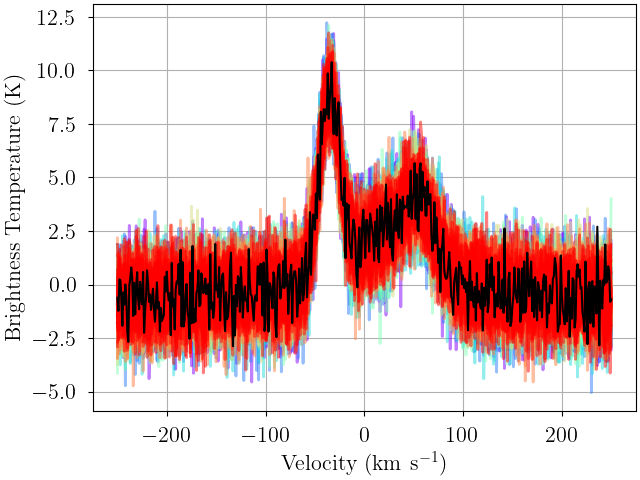

In [14]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive_smc.{ext}"
)
Image(f"{figdir}/posterior_predictive_smc.{ext}")

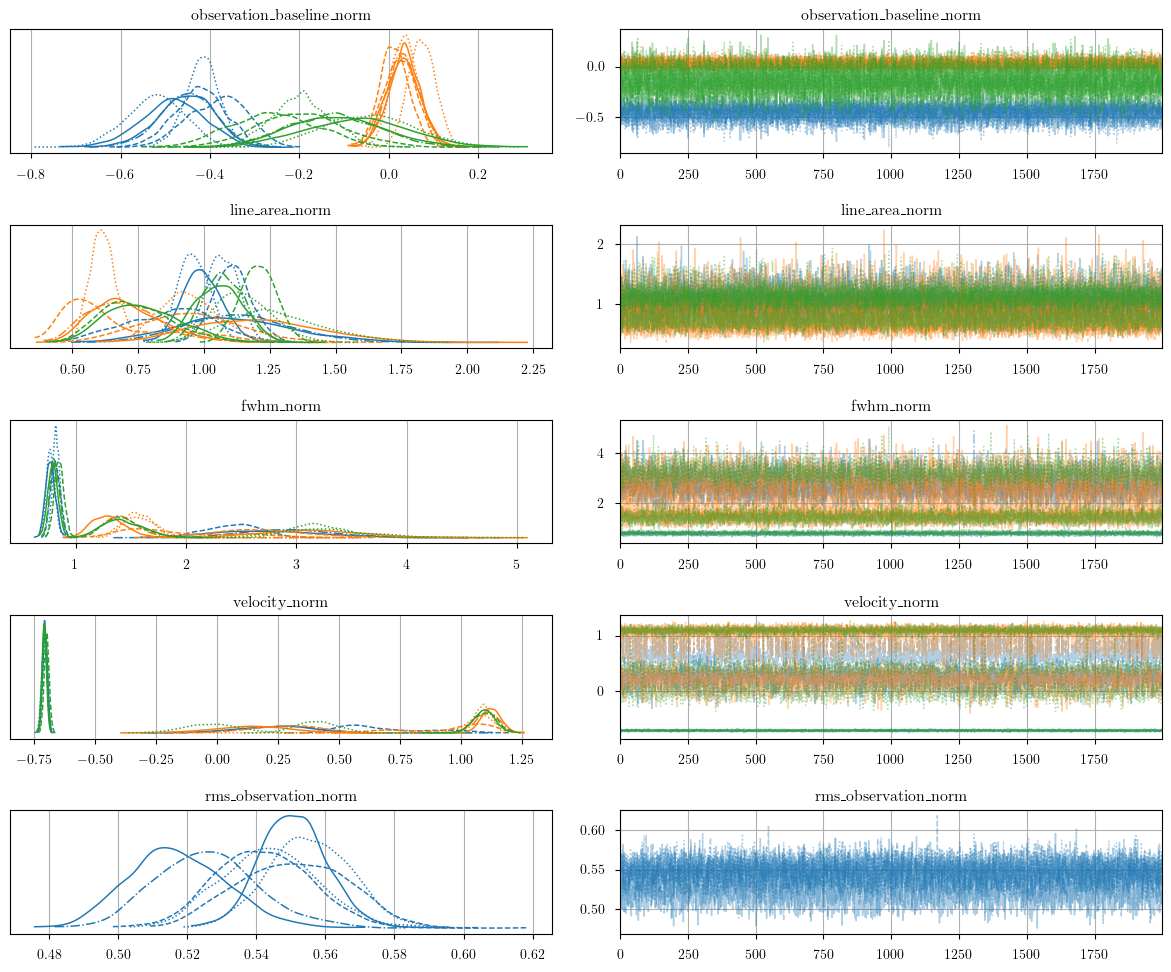

In [15]:
model.plot_traces(f"{figdir}/traces_smc.{ext}")
Image(f"{figdir}/traces_smc.{ext}")

The model has clearly not converged. The issue is actually quite subtle: due to the labeling degeneracy (i.e., the order of the clouds doesn't matter for this model), a single chain may re-order the clouds while sampling, thus causing the assumptions of SMC to break down. For this model, we can overcome this problem by *enforcing* an order on the clouds. The model `GaussLineNoiseOrdered` does just this. The clouds are *ordered* by increasing velocity, thus breaking the labeling degeneracy. Note that this only works here because our model does not intrinsically depend on the order of the clouds. This is generally true for optically thin emission, but not necessarily true if there is optically thick emission (i.e., self-absorption).

In [16]:
from bayes_spec.models import GaussLineNoiseOrdered

model = GaussLineNoiseOrdered(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [-100.0, 20.0], # lower limit and mode of k=2 gamma distribution on velocity OFFSET between clouds (km s-1)
    prior_baseline_coeff = 1.0, # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

Sampling: [fwhm_norm, line_area_norm, observation, observation_baseline_norm, rms_observation_norm, velocity_offset_norm]


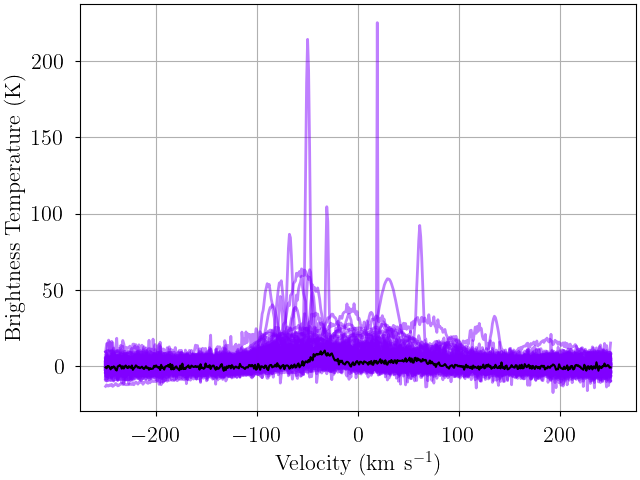

In [17]:
# prior predictive check
prior = model.prior_predictive_check(
    samples=100,  # prior predictive samples
    plot_fname=f"{figdir}/prior_predictive_ordered.{ext}",
)
Image(f"{figdir}/prior_predictive_ordered.{ext}")

In [18]:
model.sample_smc(
    draws = 2_000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8,
    threshold = 0.75, # increase threshold from default (0.5)
)

Initializing SMC sampler...
Sampling 8 chains in 8 jobs


Output()

Only 7 chains appear converged.


In [19]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


Sampling: [observation]


Output()

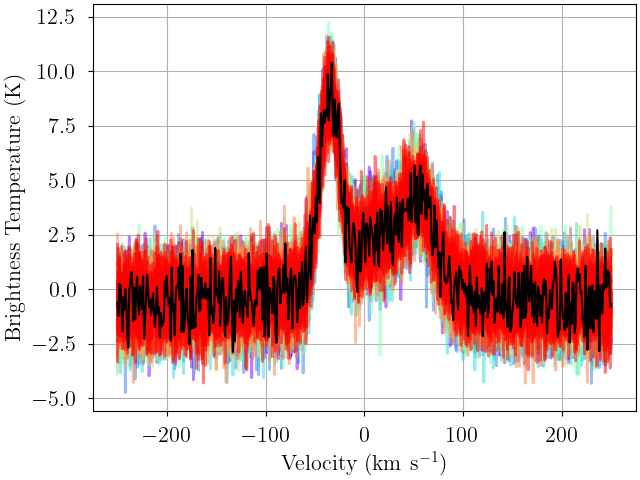

In [20]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive_smc_ordered.{ext}"
)
Image(f"{figdir}/posterior_predictive_smc_ordered.{ext}")

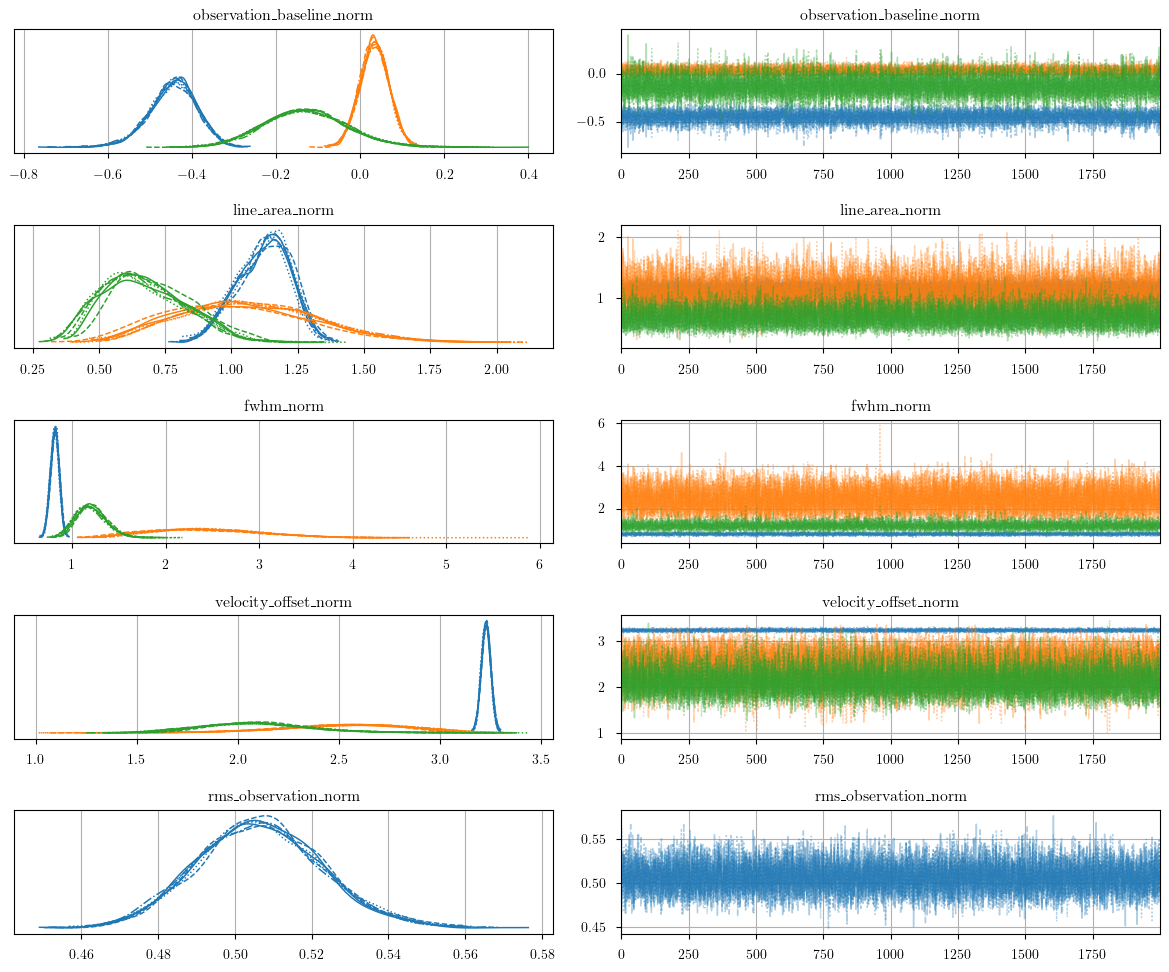

In [21]:
model.plot_traces(f"{figdir}/traces_smc_ordered.{ext}")
Image(f"{figdir}/traces_smc_ordered.{ext}")

In [22]:
pm.summary(model.trace.solution_0)

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    8.614   0.459    7.754    9.438      0.004   
amplitude[1]                    2.736   0.289    2.185    3.273      0.003   
amplitude[2]                    3.495   0.528    2.557    4.466      0.014   
fwhm[0]                        24.429   1.385   21.762   26.940      0.014   
fwhm[1]                        72.959  16.847   44.446  104.982      0.175   
fwhm[2]                        36.120   4.868   27.297   45.163      0.052   
fwhm_norm[0]                    0.814   0.046    0.725    0.898      0.000   
fwhm_norm[1]                    2.432   0.562    1.482    3.499      0.006   
fwhm_norm[2]                    1.204   0.162    0.910    1.505      0.002   
line_area[0]                  224.200  19.828  187.323  259.899      0.195   
line_area[1]                  212.093  52.270  118.039  306.996      0.532   
line_area[2]                  135.239  31.417   82.493  193.879      0.755   
line_area_norm[0]               1.121   0.099    0.937    1.299      0.001   
line_area_norm[1]               1.060   0.261    0.590    1.535      0.003   
line_area_norm[2]               0.676   0.157    0.412    0.969      0.004   
observation_baseline_norm[0]   -0.446   0.058   -0.554   -0.340      0.001   
observation_baseline_norm[1]    0.033   0.034   -0.031    0.098      0.000   
observation_baseline_norm[2]   -0.129   0.099   -0.315    0.055      0.001   
rms_observation                 1.013   0.032    0.952    1.075      0.000   
rms_observation_norm            0.507   0.016    0.476    0.537      0.000   
velocity[0]                   -35.456   0.461  -36.297  -34.572      0.004   
velocity[1]                    14.828   6.705    2.246   26.513      0.070   
velocity[2]                    56.847   2.035   52.744   60.415      0.018   
velocity_offset[0]             64.544   0.461   63.703   65.428      0.004   
velocity_offset[1]             50.284   6.632   38.090   62.106      0.070   
velocity_offset[2]             42.019   5.601   31.509   52.182      0.058   
velocity_offset_norm[0]         3.227   0.023    3.185    3.271      0.000   
velocity_offset_norm[1]         2.514   0.332    1.905    3.105      0.003   
velocity_offset_norm[2]         2.101   0.280    1.575    2.609      0.003   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.003   12366.0   12448.0   1.00  
amplitude[1]                    0.002   12433.0   12816.0   1.00  
amplitude[2]                    0.010    1485.0    9447.0   1.01  
fwhm[0]                         0.010   10077.0   13459.0   1.00  
fwhm[1]                         0.124    7044.0    5528.0   1.01  
fwhm[2]                         0.037    8846.0   11042.0   1.01  
fwhm_norm[0]                    0.000   10077.0   13459.0   1.00  
fwhm_norm[1]                    0.004    7044.0    5528.0   1.01  
fwhm_norm[2]                    0.001    8846.0   11042.0   1.01  
line_area[0]                    0.139    9938.0   12243.0   1.00  
line_area[1]                    0.377    8050.0    9617.0   1.01  
line_area[2]                    0.534     994.0    6662.0   1.01  
line_area_norm[0]               0.001    9938.0   12243.0   1.00  
line_area_norm[1]               0.002    8050.0    9617.0   1.01  
line_area_norm[2]               0.003     994.0    6662.0   1.01  
observation_baseline_norm[0]    0.000   13162.0   13164.0   1.00  
observation_baseline_norm[1]    0.000   13146.0   12543.0   1.00  
observation_baseline_norm[2]    0.001   13274.0   13457.0   1.00  
rms_observation                 0.000   13578.0   13375.0   1.00  
rms_observation_norm            0.000   13578.0   13375.0   1.00  
velocity[0]                     0.003   13230.0   12918.0   1.00  
velocity[1]                     0.061    6966.0    8090.0   1.01  
velocity[2]                     0.012   13452.0   11401.0   1.00  
velocity_offset[0]              0.003   13230.0   12918.0   1.00  
velocity_offset[1

## `nutpie`

`nutpie` is a NUTS sampler written in RUST that runs on the CPU. It's much faster than the default `pymc` implementation, but there is less control over its initialization (i.e., we can't initialize it using variational inference). Thus we only consider the `GaussLineNoiseOrdered` model.

In [23]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "nutpie",
)

After a brief delay while the model is compiled, the sampling begins. Note the speed!

In [24]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


Sampling: [observation]


Output()

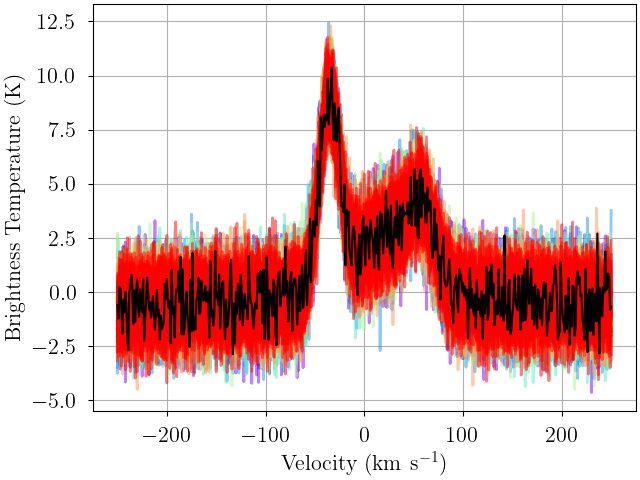

In [25]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive_nutpie.{ext}"
)
Image(f"{figdir}/posterior_predictive_nutpie.{ext}")

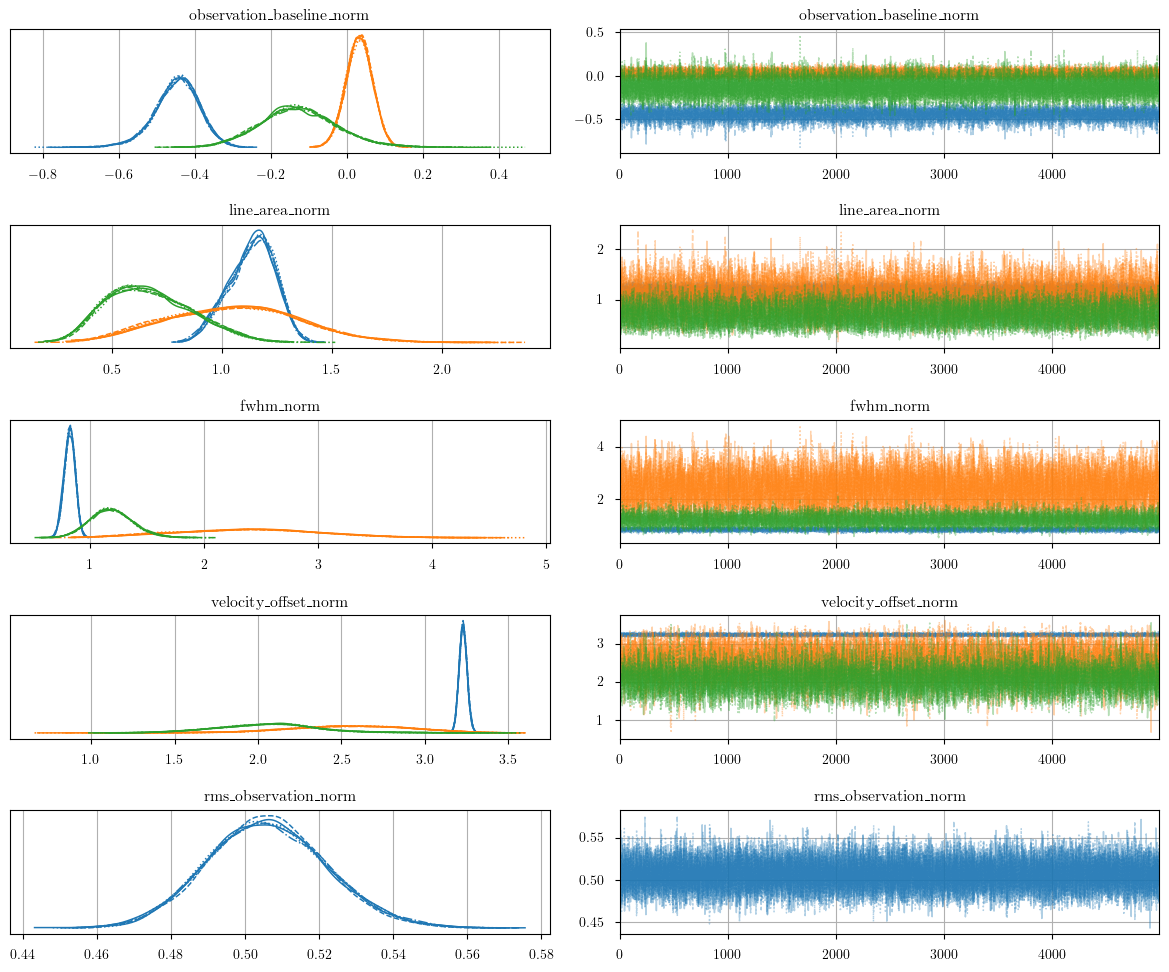

In [26]:
model.plot_traces(f"{figdir}/traces_nutpie.{ext}")
Image(f"{figdir}/traces_nutpie.{ext}")

In [27]:
pm.summary(model.trace.solution_0, var_names=model.deterministics)

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
line_area[0]     227.134  20.886  185.438  262.393      0.261    0.184   
line_area[1]     210.663  59.444   96.880  314.745      0.782    0.553   
line_area[2]     133.989  38.737   67.374  207.825      0.499    0.353   
fwhm[0]           24.592   1.451   21.713   27.170      0.015    0.011   
fwhm[1]           71.216  18.596   36.295  104.531      0.246    0.174   
fwhm[2]           35.602   5.598   25.336   46.411      0.061    0.043   
velocity[0]      -35.407   0.475  -36.272  -34.497      0.003    0.002   
velocity[1]       15.584   7.436    2.362   29.596      0.096    0.068   
velocity[2]       56.744   2.214   52.445   60.777      0.021    0.015   
amplitude[0]       8.667   0.470    7.743    9.493      0.005    0.004   
amplitude[1]       2.778   0.309    2.183    3.350      0.003    0.002   
amplitude[2]       3.488   0.636    2.392    4.666      0.008    0.006   
rms_observation    1.012   0.032    0.952    1.072      0.000    0.000   

                 ess_bulk  ess_tail  r_hat  
line_area[0]       6681.0    9422.0    1.0  
line_area[1]       5764.0    8607.0    1.0  
line_area[2]       5977.0    9735.0    1.0  
fwhm[0]            9330.0   13195.0    1.0  
fwhm[1]            5690.0    8998.0    1.0  
fwhm[2]            8446.0   12444.0    1.0  
velocity[0]       21511.0   22100.0    1.0  
velocity[1]        6114.0    7450.0    1.0  
velocity[2]       11045.0   13099.0    1.0  
amplitude[0]       8516.0   13191.0    1.0  
amplitude[1]      13034.0   17519.0    1.0  
amplitude[2]       6414.0   13194.0    1.0  
rms_observation   38950.0   22492.0    1.0

## `numpyro`

`numpyro` is a JAX-based NUTS sampler, and it can run on the GPU. `bayes_spec` provides installation options to suport CUDA GPUs (i.e., nvidia). GPUs aren't usually the way to go, unless you have a lot of them! Otherwise, you'll have to run each chain sequentially. Let's stick to the CPU.

In [28]:
import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
numpyro.set_platform('cpu')
numpyro.set_host_device_count(6)

In [29]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "numpyro",
)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Only 5 chains appear converged.


In [30]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


Sampling: [observation]
INFO:pymc.sampling.forward:Sampling: [observation]


Output()

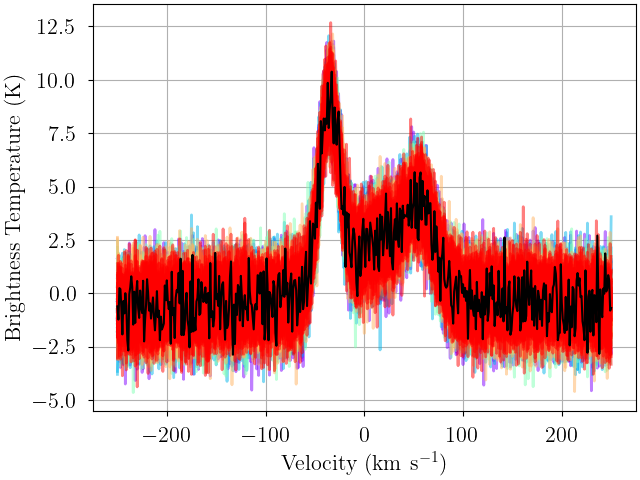

In [31]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive_numpyro.{ext}"
)
Image(f"{figdir}/posterior_predictive_numpyro.{ext}")

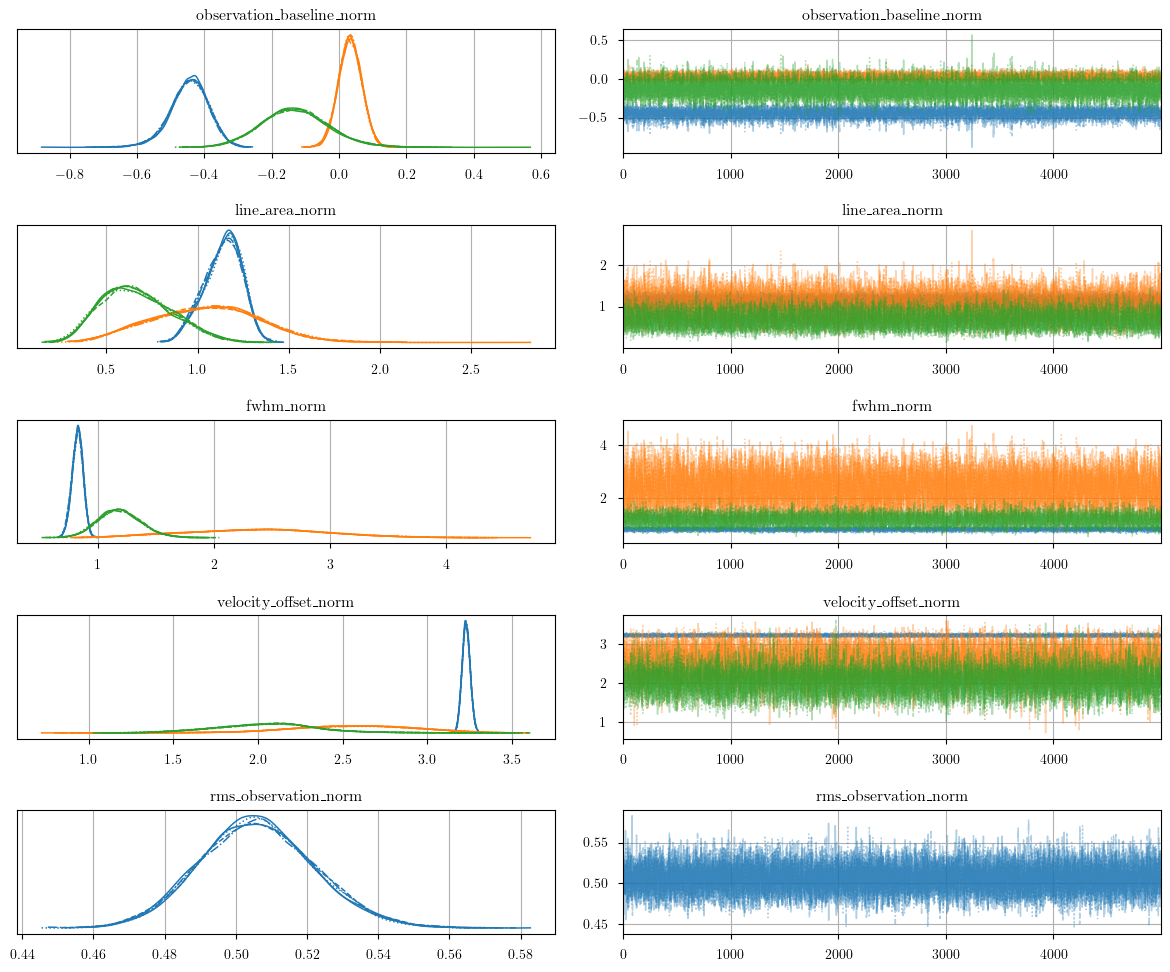

In [32]:
model.plot_traces(f"{figdir}/traces_numpyro.{ext}")
Image(f"{figdir}/traces_numpyro.{ext}")

In [33]:
pm.summary(model.trace.solution_0, var_names=model.deterministics)

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
line_area[0]     227.739  20.534  187.101  262.713      0.267    0.189   
line_area[1]     209.932  58.640  101.864  316.002      0.795    0.562   
line_area[2]     133.406  38.528   67.668  207.164      0.488    0.345   
fwhm[0]           24.633   1.431   21.872   27.254      0.016    0.011   
fwhm[1]           70.898  18.300   36.592  104.366      0.250    0.177   
fwhm[2]           35.509   5.564   25.242   46.114      0.060    0.043   
velocity[0]      -35.405   0.475  -36.312  -34.532      0.004    0.003   
velocity[1]       15.823   7.376    2.849   29.844      0.091    0.065   
velocity[2]       56.798   2.214   52.604   60.858      0.022    0.015   
amplitude[0]       8.676   0.463    7.774    9.496      0.005    0.004   
amplitude[1]       2.781   0.310    2.210    3.377      0.003    0.002   
amplitude[2]       3.482   0.637    2.402    4.694      0.008    0.006   
rms_observation    1.012   0.032    0.951    1.072      0.000    0.000   

                 ess_bulk  ess_tail  r_hat  
line_area[0]       6094.0    8936.0    1.0  
line_area[1]       5448.0    8935.0    1.0  
line_area[2]       6223.0   10142.0    1.0  
fwhm[0]            8031.0   10825.0    1.0  
fwhm[1]            5346.0    9291.0    1.0  
fwhm[2]            8413.0   11501.0    1.0  
velocity[0]       15036.0   16577.0    1.0  
velocity[1]        6564.0    9670.0    1.0  
velocity[2]       10697.0   13992.0    1.0  
amplitude[0]       8508.0   13082.0    1.0  
amplitude[1]      12771.0   17493.0    1.0  
amplitude[2]       6737.0   13022.0    1.0  
rms_observation   21154.0   17168.0    1.0

## `blackjax`

`blackjax` is another JAX-based NUTS sampler, similar to `numpyro`. It can also be run on the GPU.

In [34]:
model.sample(
    init = "auto", # must use "auto" initialization for nutpie
    tune = 5000, # tuning samples
    draws = 5000, # posterior samples
    chains = 6, # number of independent chains
    cores = 6, # number of parallel chains
    nuts_sampler = "blackjax",
)

/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.12/site-packages/pymc/sampling/jax.py:368: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(


In [35]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


Sampling: [observation]
INFO:pymc.sampling.forward:Sampling: [observation]


Output()

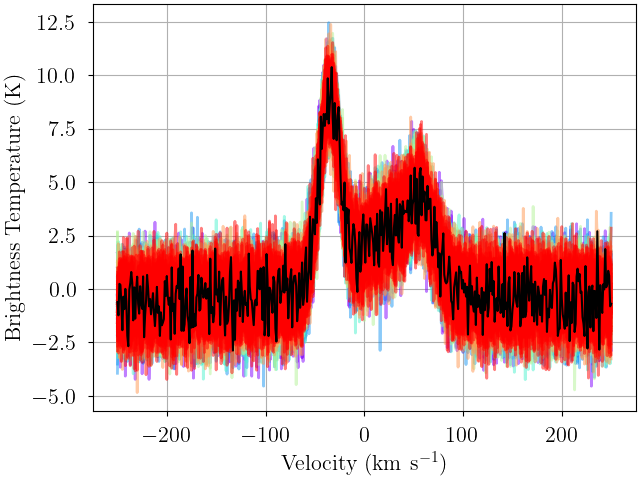

In [36]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive_blackjax.{ext}"
)
Image(f"{figdir}/posterior_predictive_blackjax.{ext}")

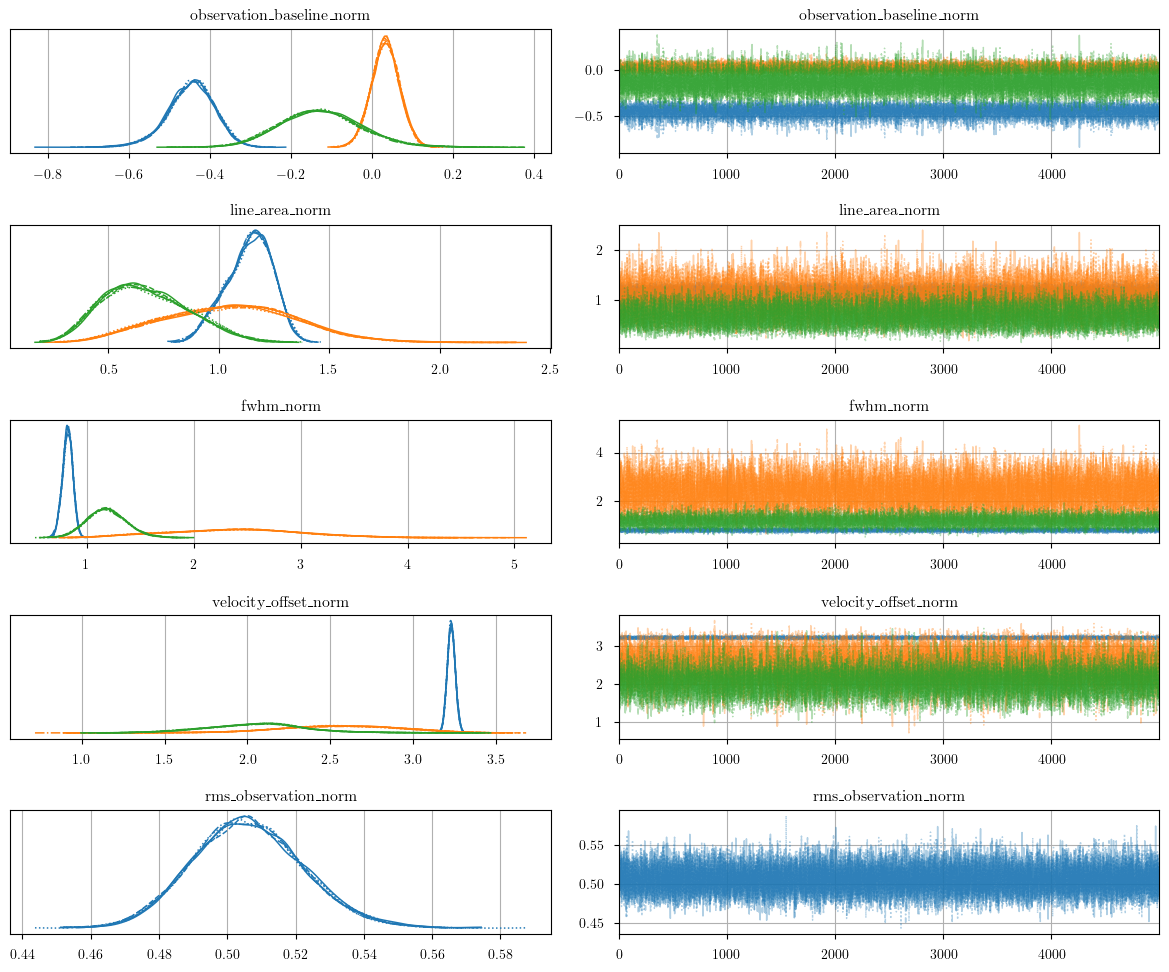

In [37]:
model.plot_traces(f"{figdir}/traces_blackjax.{ext}")
Image(f"{figdir}/traces_blackjax.{ext}")

In [38]:
pm.summary(model.trace.solution_0, var_names=model.deterministics)

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
line_area[0]     227.403  20.793  185.789  262.364      0.256    0.181   
line_area[1]     210.289  59.523  100.007  317.356      0.745    0.527   
line_area[2]     133.997  38.529   67.211  206.222      0.449    0.317   
fwhm[0]           24.598   1.441   21.851   27.278      0.015    0.011   
fwhm[1]           71.066  18.603   35.933  104.421      0.238    0.168   
fwhm[2]           35.568   5.541   25.141   45.888      0.056    0.039   
velocity[0]      -35.405   0.475  -36.301  -34.516      0.004    0.003   
velocity[1]       15.641   7.393    2.790   30.009      0.085    0.060   
velocity[2]       56.745   2.190   52.518   60.730      0.020    0.014   
amplitude[0]       8.676   0.469    7.778    9.524      0.005    0.003   
amplitude[1]       2.778   0.308    2.194    3.348      0.002    0.002   
amplitude[2]       3.492   0.638    2.425    4.714      0.007    0.005   
rms_observation    1.012   0.032    0.953    1.074      0.000    0.000   

                 ess_bulk  ess_tail  r_hat  
line_area[0]       6813.0   11052.0    1.0  
line_area[1]       6340.0    9697.0    1.0  
line_area[2]       7348.0   12396.0    1.0  
fwhm[0]            9014.0   13195.0    1.0  
fwhm[1]            6086.0    9583.0    1.0  
fwhm[2]            9829.0   13278.0    1.0  
velocity[0]       16999.0   19130.0    1.0  
velocity[1]        7692.0    9791.0    1.0  
velocity[2]       12541.0   16053.0    1.0  
amplitude[0]       9450.0   14159.0    1.0  
amplitude[1]      15435.0   19126.0    1.0  
amplitude[2]       7933.0   15531.0    1.0  
rms_observation   25082.0   20246.0    1.0